# 문제정의

- 실제 개 고양이 이미지를 활용해서 개와 고양이를 분류

- 데이터 정리 (훈련데이터와 테스터 폴더로 필요한 이미지 파일을 이동)
- ImageDataGenerator를 이용해서 전처리
- CNN으로 개고양이 분류 모델을 설계하고 학습

- 증강학습 : 이미지데이터 늘리기
- 전이학습
   - 특성추출
   - 미세조정
   
- 과대적합방지
  - Dropout
  - BatchNormalization

## train.zip 파일의 압축을 푼다

In [29]:
import os, os.path, shutil, zipfile

In [3]:
zip_ref = zipfile.ZipFile("./data/train.zip", "r")
zip_ref.extractall("./data/")
zip_ref.close()

## 훈련데이터 2000개, 테스트데이터 500개씩 샘플링

In [30]:
base_dir = "./data/cat_dog"
if not os.path.exists(base_dir) :
    os.mkdir(base_dir)
    
train_dir = "./data/cat_dog/train"
if not os.path.exists(train_dir) :    
    os.mkdir(train_dir)  
    
test_dir = "./data/cat_dog/test"
if not os.path.exists(test_dir) :    
    os.mkdir(test_dir)     
    
train_dog_dir = "./data/cat_dog/train/dog"  
if not os.path.exists(train_dog_dir) :    
    os.mkdir(train_dog_dir) 
    
train_cat_dir = "./data/cat_dog/train/cat"  
if not os.path.exists(train_cat_dir) :    
    os.mkdir(train_cat_dir)     
    
test_dog_dir = "./data/cat_dog/test/dog"  
if not os.path.exists(test_dog_dir) :    
    os.mkdir(test_dog_dir) 
    
test_cat_dir = "./data/cat_dog/test/cat"  
if not os.path.exists(test_cat_dir) :    
    os.mkdir(test_cat_dir)      

In [19]:
train_dir2 = "./data/train"

# 각 폴더로 이미지들을 복사
# 0번부터 1999번의 고양이 이미지를 train/cat 폴더로 이동
fnames = ["cat.{}.jpg".format(i) for i in range(2000)]
for fname in fnames :
    src = os.path.join(train_dir2, fname)
    dst = os.path.join(train_cat_dir, fname)
    shutil.copyfile(src, dst)

# 2000번부터 2499번의 고양이 이미지를 test/cat 폴더로 이동
fnames = ["cat.{}.jpg".format(i) for i in range(2000, 2500)]
for fname in fnames :
    src = os.path.join(train_dir2, fname)
    dst = os.path.join(test_cat_dir, fname)
    shutil.copyfile(src, dst)
    
# 0번부터 1999번의 개 이미지를 train/dog 폴더로 이동
fnames = ["dog.{}.jpg".format(i) for i in range(2000)]
for fname in fnames :
    src = os.path.join(train_dir2, fname)
    dst = os.path.join(train_dog_dir, fname)
    shutil.copyfile(src, dst)
    
# 2000번부터 2499번의 개 이미지를 test/dog 폴더로 이동
fnames = ["dog.{}.jpg".format(i) for i in range(2000, 2500)]
for fname in fnames :
    src = os.path.join(train_dir2, fname)
    dst = os.path.join(test_dog_dir, fname)
    shutil.copyfile(src, dst)

In [31]:
# 각 폴더의 이미지 수 확인
print("훈련(개) 이미지수 : {}".format(len(os.listdir(train_dog_dir))))
print("훈련(고양이) 이미지수 : {}".format(len(os.listdir(train_cat_dir))))
print("테스트(개) 이미지수 : {}".format(len(os.listdir(test_dog_dir))))
print("테스트(고양이) 이미지수 : {}".format(len(os.listdir(test_cat_dir))))

훈련(개) 이미지수 : 2000
훈련(고양이) 이미지수 : 2000
테스트(개) 이미지수 : 500
테스트(고양이) 이미지수 : 500


## 이미지 전처리

- 0-255 범위의 픽셀값을 0.0-1.0 범위로 변경
- 이미지 크기를 동일하게 변환
- 이미지에 라벨을 부여

In [34]:
# ImageDataGenerator : 반복해서 이미지를 전처리하는 라이브러리
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 정규화 설정 (0-255 -> 0.0-1.0변환)
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# 학습용 이미지 전처리 설정
train_generator = train_gen.flow_from_directory(
    # 해당 폴더
    train_dir,
    # 이미지 크기를 동일하게 변환
    target_size = (150, 150),
    batch_size = 20,    # 한 번에 처리하는 이미지의 개수
    # binary : 0과 1로 라벨링 (디렉토리명의 알파벳순으로)
    # categorical : 0부터의 개수만큼 1씩 증가시켜 라벨링 
    #               (디렉토리명의 알파벳순으로)
    class_mode = "binary"
)

test_generator = test_gen.flow_from_directory(
    # 해당 폴더
    test_dir,
    # 이미지 크기를 동일하게 변환
    target_size = (150, 150),
    batch_size = 20,    # 한 번에 처리하는 이미지의 개수
    # binary : 0과 1로 라벨링 (디렉토리명의 알파벳순으로)
    # categorical : 0부터의 개수만큼 1씩 증가시켜 라벨링 
    #               (디렉토리명의 알파벳순으로)
    class_mode = "binary"
)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
# 라벨링 결과 확인
train_generator.class_indices, test_generator.class_indices

({'cat': 0, 'dog': 1}, {'cat': 0, 'dog': 1})

## 신경망 설계 (CNN)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model1 = Sequential()

# 특성 추출기 모델
#  - 최종 특성의 크기가 10x10 정도 될때까지 CNN (Conv2D+Pooling) 층을 쌓음
#  - 각 층의 필터의 크기를 몇 개씩 설계할 것인가 
#    - 인코딩 : 필터의 개숫를 늘려가는 방식
#    - 디코딩 : 필터의 개수를 줄여가는 방식
model1.add(Conv2D(filters=32, kernel_size=(3, 3), 
                  input_shape=(150, 150, 3)))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=64, kernel_size=(3, 3)))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3, 3)))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3, 3)))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# 분류기 모델
model1.add(Dense(units=512, activation="relu"))
# loss = "binary_crossentropy"
model1.add(Dense(units=1, activation="sigmoid"))  
# loss = "categorical_crossentropy"
#model1.add(Dense(units=2, activation="softmax")) 

model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_14 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_15 (Activation)   (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 34, 34, 128)      

In [37]:
model1.compile(loss="binary_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [38]:
h1 = model1.fit(train_generator, epochs=10,
                validation_data=test_generator)

Epoch 1/10
200/200 [==============================] - 54s 264ms/step - loss: 0.6961 - accuracy: 0.5251 - val_loss: 0.6708 - val_accuracy: 0.6200
Epoch 2/10
200/200 [==============================] - 45s 226ms/step - loss: 0.6619 - accuracy: 0.5935 - val_loss: 0.6402 - val_accuracy: 0.6380
Epoch 3/10
200/200 [==============================] - 46s 228ms/step - loss: 0.6289 - accuracy: 0.6529 - val_loss: 0.6272 - val_accuracy: 0.6410
Epoch 4/10
200/200 [==============================] - 45s 225ms/step - loss: 0.5631 - accuracy: 0.7043 - val_loss: 0.5863 - val_accuracy: 0.6990
Epoch 5/10
200/200 [==============================] - 46s 230ms/step - loss: 0.5035 - accuracy: 0.7588 - val_loss: 0.5320 - val_accuracy: 0.7550
Epoch 6/10
200/200 [==============================] - 45s 226ms/step - loss: 0.4380 - accuracy: 0.7953 - val_loss: 0.5518 - val_accuracy: 0.7270
Epoch 7/10
200/200 [==============================] - 46s 232ms/step - loss: 0.3549 - accuracy: 0.8430 - val_loss: 0.5839 - val_ac

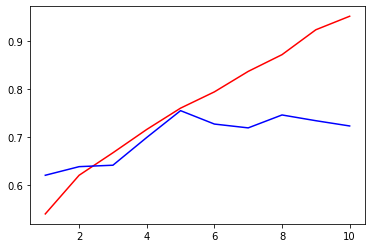

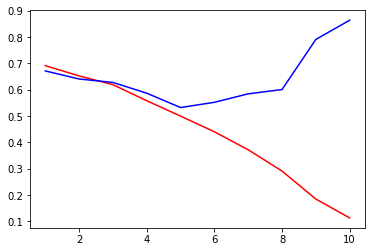

In [41]:
# 결과 시각화 하기
import matplotlib.pyplot as plt

acc = h1.history["accuracy"]
val_acc = h1.history["val_accuracy"]
loss = h1.history["loss"]
val_loss = h1.history["val_loss"]

e = range(1, len(acc)+1)

plt.plot(e, acc, "r", label="train acc")
plt.plot(e, val_acc, "b", label="test acc")
plt.show()

plt.plot(e, loss, "r", label="train loss")
plt.plot(e, val_loss, "b", label="test loss")
plt.show()

In [43]:
# 예측하기
import numpy as np

pred = model1.predict_generator(test_generator)

pred_val = np.where(pred > .5, "개", "고양이")

for i in range(10) :
    print(test_generator.filenames[i])
    print(pred_val[i])

D:\anaconda3\envs\GPU\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


cat\cat.2000.jpg
['고양이']
cat\cat.2001.jpg
['개']
cat\cat.2002.jpg
['고양이']
cat\cat.2003.jpg
['개']
cat\cat.2004.jpg
['고양이']
cat\cat.2005.jpg
['개']
cat\cat.2006.jpg
['개']
cat\cat.2007.jpg
['개']
cat\cat.2008.jpg
['고양이']
cat\cat.2009.jpg
['개']


## 데이터 확장 (data augmentation, 증식)을 이용한 성능개선

- 원본 이미지 데이터에 변형을 주어서 변형된 데이터를 CNN에 입력해주는 방법
- 데이터의 수가 증가하는 효과가 있음
- 변형 방법 : 회전, 이동, 확대/축소, 뒤집기, 기울림, 밝기조정 등
- 증식을 하면 오차가 커지므로 epochs 값을 늘려서 학습을 해주어야 함
- 증식은 훈련데이터에만 적용해야 함

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 증식 설정 (ImageDataGenerator 활용) 
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,   #20도 내로 회전
    width_shift_range = 0.2,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode = "nearest"    # 이미지 변형시 깨지는 부분을 보상
)

test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,    
    class_mode = "binary"
)

test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,    
    class_mode = "binary"
)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model2 = Sequential()

# 특성 추출기 모델
#  - 최종 특성의 크기가 10x10 정도 될때까지 CNN (Conv2D+Pooling) 층을 쌓음
#  - 각 층의 필터의 크기를 몇 개씩 설계할 것인가 
#    - 인코딩 : 필터의 개숫를 늘려가는 방식
#    - 디코딩 : 필터의 개수를 줄여가는 방식
model2.add(Conv2D(filters=32, kernel_size=(3, 3), 
                  input_shape=(150, 150, 3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters=64, kernel_size=(3, 3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3, 3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3, 3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

# 분류기 모델
model2.add(Dense(units=512, activation="relu"))
# loss = "binary_crossentropy"
model2.add(Dense(units=1, activation="sigmoid"))  
# loss = "categorical_crossentropy"
#model1.add(Dense(units=2, activation="softmax")) 

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_22 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_23 (Activation)   (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 34, 34, 128)      

In [49]:
model2.compile(loss="binary_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

In [ ]:
h2 = model2.fit(train_generator, epochs=30,
                validation_data=test_generator)

## 전이학습 (Transfer Learning)을 이용한 성능 개선

- 특성추출 : 기존의 모델에 있는 CNN층을 그대로 가져다가 사용
  - 가져온 CNN 층에 대해서 오차역전파를 수행하지 않음 (동결)
- 미세조정 : 기존의 모델에 있는 CNN층을 그대로 가져다가 사용
  - 가져온 CNN 층에 대해서 분류기와 가까운 층들에 대해 오차역전파를 수행함

In [50]:
# VGG16 모델을 가져온다
from tensorflow.keras.applications import VGG16

# weights : 어떤 가중치를 가져올 것인지 설정
# include_top : 분류기도 가져올 것인지 설정
# input_shape : 우리 모델에서 사용할 입력 이미지 크기
conv_base = VGG16(weights="imagenet",
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model3 = Sequential()

# VGG16 모델을 우리 모델에 연결
model3.add(conv_base)

model3.add(Flatten())

# 분류기 모델
model3.add(Dense(units=512, activation="relu"))
model3.add(Dense(units=1, activation="sigmoid"))  

model3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 18,910,017
Non-trainable params: 0
_________________________________________________________________


- 동결 : 가져온 모델로는 오차역전파가 되지 않도록 막는 것

In [53]:
# 학습이 되는 층을 확인
# 학습가능한 VGG16모델의 파라미터
#      - Conv2 층이 13개이므로 각 w(필터), b가 있어 26개
# 학습가능한 우리 모델의 파라미터 : Dense가 2개에 w, b가 있어 총 4개
print("학습가능한 파라미터 수 : ", len(model3.trainable_weights))

학습가능한 층의 수 :  30


In [54]:
# 동결작업 : VGG16의 파라미터는 학습이 되지 않도록 막음
conv_base.trainable = False

In [55]:
print("학습가능한 파라미터 수 : ", len(model3.trainable_weights))

학습가능한 파라미터 수 :  4


In [56]:
model3.compile(loss="binary_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

h3 = model3.fit(train_generator, epochs=10,
                validation_data=test_generator)

Epoch 1/10
200/200 [==============================] - 119s 594ms/step - loss: 0.5856 - accuracy: 0.7618 - val_loss: 0.2500 - val_accuracy: 0.8980
Epoch 2/10
200/200 [==============================] - 121s 606ms/step - loss: 0.2921 - accuracy: 0.8689 - val_loss: 0.2789 - val_accuracy: 0.8770
Epoch 3/10
200/200 [==============================] - 123s 615ms/step - loss: 0.2761 - accuracy: 0.8747 - val_loss: 0.2472 - val_accuracy: 0.8890
Epoch 4/10
200/200 [==============================] - 123s 617ms/step - loss: 0.2355 - accuracy: 0.9029 - val_loss: 0.2379 - val_accuracy: 0.8950
Epoch 5/10
200/200 [==============================] - 124s 618ms/step - loss: 0.2368 - accuracy: 0.9054 - val_loss: 0.2658 - val_accuracy: 0.8780
Epoch 6/10
200/200 [==============================] - 125s 626ms/step - loss: 0.2207 - accuracy: 0.9072 - val_loss: 0.2956 - val_accuracy: 0.8780
Epoch 7/10
200/200 [==============================] - 121s 605ms/step - loss: 0.2198 - accuracy: 0.9079 - val_loss: 0.2428 -

### 전이학습 : 미세조정

- 분류기에서 가까운 층의 동결을 풀어주어서 학습이 되도록 조정
- 미세조정을 하면 우리모델과 가져온 모델 간의 매칭도가 향상

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model4 = Sequential()

# VGG16 모델을 우리 모델에 연결
model4.add(conv_base)

model4.add(Flatten())

# 분류기 모델
model4.add(Dense(units=512, activation="relu"))
model4.add(Dense(units=1, activation="sigmoid"))  

model4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 18,910,017
Trainable params: 11,274,753
Non-trainable params: 7,635,264
_________________________________________________________________


In [62]:
# VGG16의 전체 층의 동결을 푼다
conv_base.trainable = True

In [66]:
# VGG16의 5층만 동결 (분류기에서 가장 가까운 층)
set_trainable = False  # 동결 여부

for layer in conv_base.layers :
    if layer.name == "block5_conv3" :
        set_trainable = True
    
    if set_trainable :
        layer.trainable = True    # 5층의 동결을 푼다
    else :
        layer.trainable = False   # 1-4층은 동결        

In [67]:
print("학습가능한 파라미터 수 : ", len(model4.trainable_weights))

학습가능한 파라미터 수 :  6


In [65]:
model4.compile(loss="binary_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

h4 = model4.fit(train_generator, epochs=10,
                validation_data=test_generator)

Epoch 1/10
200/200 [==============================] - 149s 740ms/step - loss: 0.8117 - accuracy: 0.4932 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 2/10
200/200 [==============================] - 153s 766ms/step - loss: 0.7502 - accuracy: 0.5030 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
 74/200 [==========>...................] - ETA: 1:27 - loss: 0.6931 - accuracy: 0.5127

KeyboardInterrupt: 